In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import os
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.stats import entropy as kl_divergence
import re






In [5]:
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:i+cell_height, j:j+cell_width]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy




Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/1686915042.py:76: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):


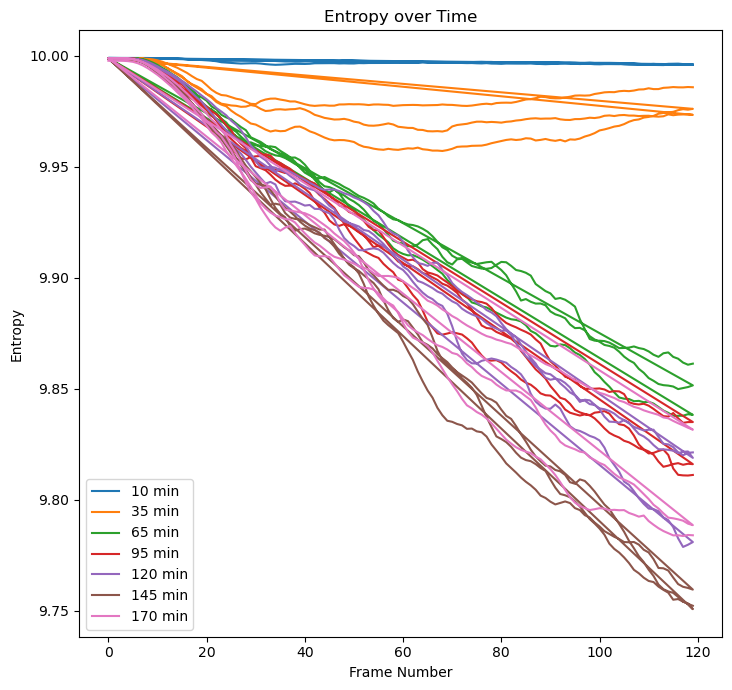

In [6]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            # Adjust the cell to not go out of bounds
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
    
    return entropy_over_time

# Assuming base_path is the directory containing your 'posX' folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

video_data = []

for exp_folder in experiment_folders:
    # Extract incubation time from the experiment folder name
    incubation_time_str = exp_folder.split('_')[1]  # '10_min'
    incubation_time = int(incubation_time_str.split('_')[0])  # 10
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")  # Print the current folder being processed
        entropy_over_time = process_image_sequence(pos_folder)
        
        for i, entropy in enumerate(entropy_over_time):
            video_data.append({
                'Frame Number': i,
                'Entropy': entropy,
                'Incubation Time': incubation_time
            })

# Create DataFrame
df = pd.DataFrame(video_data)

# Display the DataFrame (optional)
print(df.head())

# Plotting the results (optional)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

plt.tight_layout()
plt.show()


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/2870083532.py:116: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/2870083532.py:125: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):


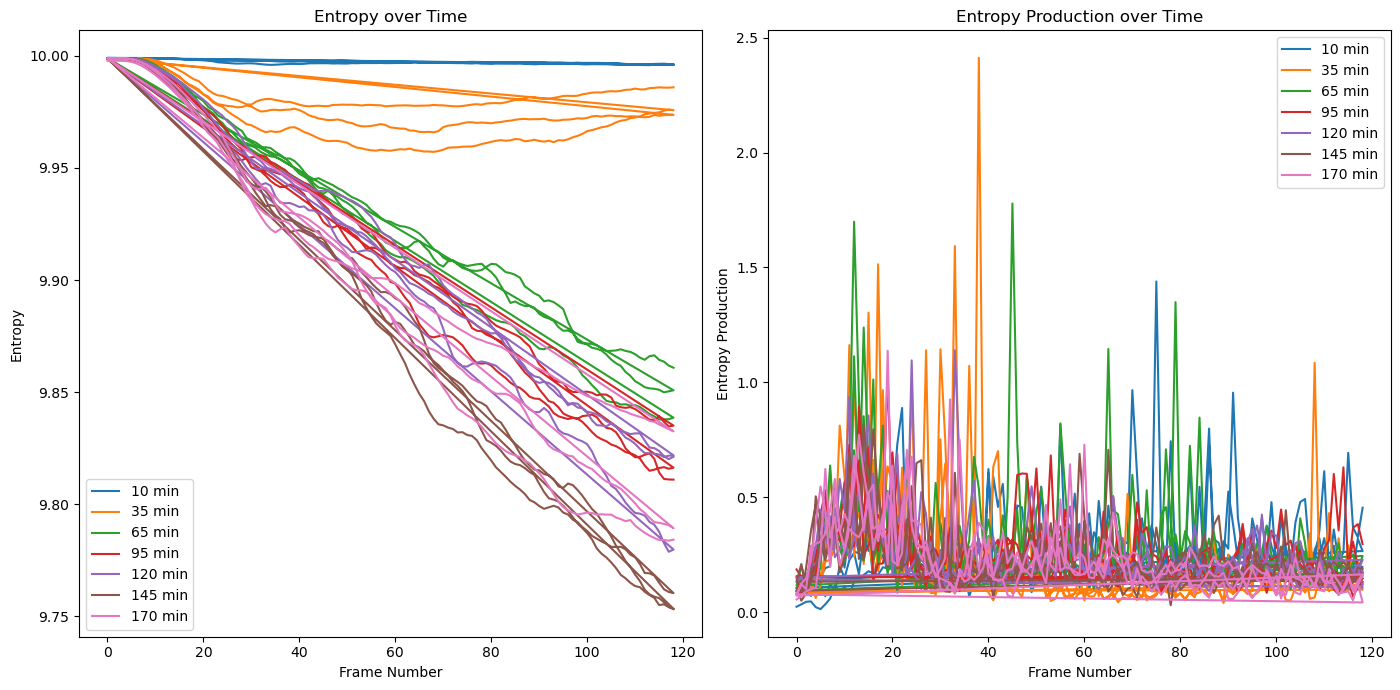

In [7]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Calculate the probability distribution with a small epsilon
def calculate_probability_distribution(image_np, grid_size=(32, 32), num_bins=100, epsilon=1e-8):
    height, width = image_np.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    intensity_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image_np[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            intensity_values.append(mean_intensity)

    intensity_values = np.array(intensity_values)
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    return probability_distribution

# Calculate entropy for grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy

# Process each image sequence and return entropy and probability distributions
def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    probability_distributions = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        # Calculate entropy
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
        
        # Calculate probability distribution
        prob_dist = calculate_probability_distribution(image_np)
        probability_distributions.append(prob_dist)
    
    return entropy_over_time, probability_distributions

# Calculate local entropy production from probability distributions
def calculate_local_entropy_production(prob_dists):
    entropy_production = []
    for t in range(1, len(prob_dists)):
        p_t = prob_dists[t-1]
        p_t1 = prob_dists[t]
        entropy_production.append(np.sum(p_t1 * np.log(p_t1 / (p_t + np.finfo(float).eps))))
    return np.array(entropy_production)

# Assuming base_path is the directory containing your 'posX' folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

video_data = []

for exp_folder in experiment_folders:
    # Extract incubation time from the experiment folder name
    incubation_time_str = exp_folder.split('_')[1]  # '10_min'
    incubation_time = int(incubation_time_str.split('_')[0])  # 10
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")  # Print the current folder being processed
        entropy_over_time, prob_dists = process_image_sequence(pos_folder)
        
        # Calculate entropy production
        entropy_production = calculate_local_entropy_production(prob_dists)

        for i, (entropy, entropy_prod) in enumerate(zip(entropy_over_time, entropy_production)):
            video_data.append({
                'Frame Number': i,
                'Entropy': entropy,
                'Entropy Production': entropy_prod,
                'Incubation Time': incubation_time
            })

# Create DataFrame
df = pd.DataFrame(video_data)

# Plotting the results
plt.figure(figsize=(21, 7))

# Plot Entropy
plt.subplot(1, 3, 1)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# Plot Entropy Production
plt.subplot(1, 3, 2)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy Production'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production')
plt.title('Entropy Production over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            # Ensure we do not exceed the image dimensions
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

# Function to calculate KL divergence relative to a uniform distribution
def calculate_grid_kl_divergence(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    kl_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            cell_intensity = np.mean(cell)
            kl_values.append(cell_intensity)

    kl_values = np.array(kl_values)
    kl_values /= np.sum(kl_values) + np.finfo(float).eps  # Normalize to sum to 1

    uniform_distribution = np.ones_like(kl_values) / len(kl_values)
    kl_divergence_value = kl_divergence(kl_values, uniform_distribution)

    return kl_divergence_value

# Process a sequence of TIFF images to calculate entropy and KL divergence over time
def process_image_sequence(tiff_folder_path):
    tiff_files = [f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')]
    tiff_files.sort()  # Ensure files are processed in order
    entropy_over_time = []
    kl_divergence_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        size = 8
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        kl_divergence_value = calculate_grid_kl_divergence(image_np)
        
        entropy_over_time.append(entropy)
        kl_divergence_over_time.append(kl_divergence_value)
    
    return entropy_over_time, kl_divergence_over_time

# Analyze entropy production based on entropy and KL divergence over time
def analyze_entropy_production(entropy_over_time, kl_divergence_over_time):
    delta_entropy_over_time = np.diff(entropy_over_time)
    mutual_information_estimation = kl_divergence_over_time[:-1]
    
    entropy_production_rate = delta_entropy_over_time - mutual_information_estimation
    
    if len(entropy_production_rate) == 0:
        return None
    
    avg_entropy_production_rate = np.mean(entropy_production_rate)
    total_entropy_production = np.sum(entropy_production_rate)
    
    bins = np.linspace(np.min(entropy_production_rate), np.max(entropy_production_rate), 100)
    hist, _ = np.histogram(entropy_production_rate, bins=bins, density=True)
    entropy_production_rate_distribution = hist
    
    rate_function = -np.log(entropy_production_rate_distribution + np.finfo(float).eps)
    
    time_intervals = [1, 5, 10, 20, 50, 100]
    avg_entropy_production_rates = []
    for interval in time_intervals:
        avg_rate = np.mean(entropy_production_rate[:interval])
        avg_entropy_production_rates.append(avg_rate)
    
    return entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, rate_function, time_intervals, avg_entropy_production_rates

# Base folder path for the data
base_folder = '/Volumes/SL_2023/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

all_data = []

# Process each experiment folder
for exp_folder in experiment_folders:
    incubation_time_str = exp_folder.split('_')[1]
    incubation_time = int(incubation_time_str.split('_')[0])
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")
        entropy_over_time, kl_divergence_over_time = process_image_sequence(pos_folder)

        entropy_production_data = analyze_entropy_production(entropy_over_time, kl_divergence_over_time)

        if entropy_production_data is not None:
            entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, rate_function, time_intervals, avg_entropy_production_rates = entropy_production_data
            
            data = {
                'Incubation Time': incubation_time,
                'Position': pos_folder,
                'Entropy over Time': entropy_over_time,
                'KL Divergence over Time': kl_divergence_over_time,
                'Entropy Production Rate': entropy_production_rate,
                'Average Entropy Production Rate': avg_entropy_production_rate,
                'Total Entropy Production': total_entropy_production,
                'Bins': bins,
                'Entropy Production Rate Distribution': entropy_production_rate_distribution,
                'Rate Function': rate_function,
                'Time Intervals': time_intervals,
                'Average Entropy Production Rates': avg_entropy_production_rates
            }
            
            all_data.append(data)
        else:
            print(f"Skipping folder {pos_folder} due to insufficient data for entropy production analysis.")

# Convert the data to a DataFrame
df = pd.DataFrame(all_data)

# Plot the results



Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_35_min_no_6.1_1/Pos0
Processing folder: /Volumes/S

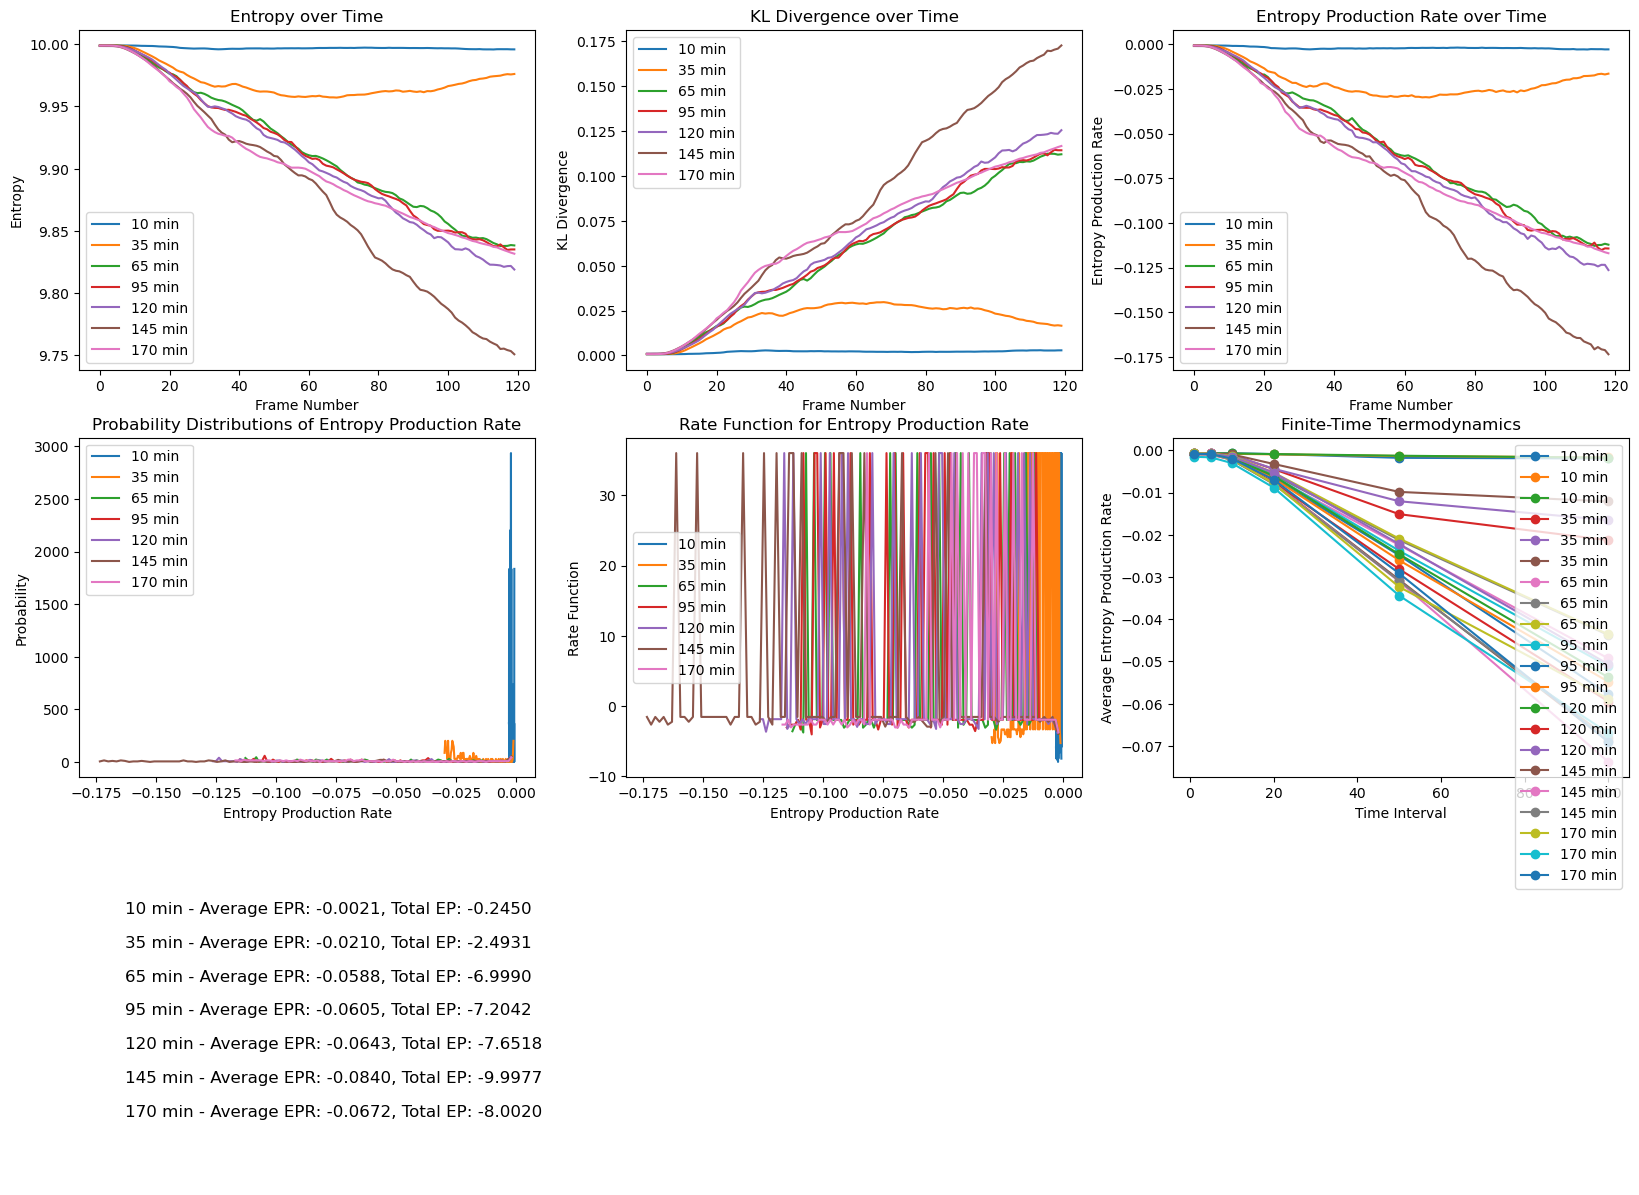

In [10]:
plt.figure(figsize=(20, 15))

# Entropy over Time
plt.subplot(3, 3, 1)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# KL Divergence over Time
plt.subplot(3, 3, 2)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['KL Divergence over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Time')
plt.legend()

# Entropy Production Rate over Time
plt.subplot(3, 3, 3)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy Production Rate'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production Rate')
plt.title('Entropy Production Rate over Time')
plt.legend()

# Probability Distributions of Entropy Production Rate
plt.subplot(3, 3, 4)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Entropy Production Rate Distribution'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Probability')
plt.title('Probability Distributions of Entropy Production Rate')
plt.legend()

# Rate Function for Entropy Production Rate
plt.subplot(3, 3, 5)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Rate Function'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Rate Function')
plt.title('Rate Function for Entropy Production Rate')
plt.legend()

# Finite-Time Thermodynamics
plt.subplot(3, 3, 6)
for incubation_time, group in df.groupby('Incubation Time'):
    for time_intervals, avg_entropy_production_rates in zip(group['Time Intervals'], group['Average Entropy Production Rates']):
        plt.plot(time_intervals, avg_entropy_production_rates, 'o-', label=f'{incubation_time} min')
plt.xlabel('Time Interval')
plt.ylabel('Average Entropy Production Rate')
plt.title('Finite-Time Thermodynamics')
plt.legend()

# Summary of Average and Total Entropy Production
plt.subplot(3, 3, 7)
plt.axis('off')
y_position = 0.8  # Start position for text
for incubation_time, group in df.groupby('Incubation Time'):
    avg_epr = group['Average Entropy Production Rate'].iloc[0]
    total_ep = group['Total Entropy Production'].iloc[0]
    plt.text(0.1, y_position, f'{incubation_time} min - Average EPR: {avg_epr:.4f}, Total EP: {total_ep:.4f}', fontsize=12)
    y_position -= 0.1  # Move to the next line for the next summary



In [11]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i + cell_height, height), j:min(j + cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

# Function to calculate KL divergence with respect to a uniform distribution
def calculate_grid_kl_divergence(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    kl_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i + cell_height, height), j:min(j + cell_width, width)]
            cell_intensity = np.mean(cell)
            kl_values.append(cell_intensity)

    kl_values = np.array(kl_values)
    kl_values /= np.sum(kl_values)

    uniform_distribution = np.ones_like(kl_values) / len(kl_values)
    kl_divergence_value = kl_divergence(kl_values, uniform_distribution)

    return kl_divergence_value

# Process each image sequence and return entropy and KL divergence over time
def process_image_sequence(tiff_folder_path):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    kl_divergence_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        kl_divergence_value = calculate_grid_kl_divergence(image_np)
        
        entropy_over_time.append(entropy)
        kl_divergence_over_time.append(kl_divergence_value)
    
    return entropy_over_time, kl_divergence_over_time

# Analyze the entropy production based on entropy and KL divergence over time
def analyze_entropy_production(entropy_over_time, kl_divergence_over_time):
    delta_entropy_over_time = np.diff(entropy_over_time)
    mutual_information_estimation = kl_divergence_over_time[:-1]
    
    entropy_production_rate = delta_entropy_over_time - mutual_information_estimation
    
    if len(entropy_production_rate) == 0:
        return None
    
    avg_entropy_production_rate = np.mean(entropy_production_rate)
    total_entropy_production = np.sum(entropy_production_rate)
    
    bins = np.linspace(np.min(entropy_production_rate), np.max(entropy_production_rate), 100)
    hist, _ = np.histogram(entropy_production_rate, bins=bins, density=True)
    entropy_production_rate_distribution = hist
    
    neg_entropy_production_rate = -entropy_production_rate
    neg_hist, _ = np.histogram(neg_entropy_production_rate, bins=bins, density=True)
    neg_entropy_production_rate_distribution = neg_hist
    
    ratio = entropy_production_rate_distribution / (neg_entropy_production_rate_distribution + np.finfo(float).eps)
    expected_ratio = np.exp(bins[:-1])
    
    rate_function = -np.log(entropy_production_rate_distribution + np.finfo(float).eps)
    
    time_intervals = [1, 5, 10, 20, 50, 100]
    avg_entropy_production_rates = []
    for interval in time_intervals:
        avg_rate = np.mean(entropy_production_rate[:interval])
        avg_entropy_production_rates.append(avg_rate)
    
    return entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, neg_entropy_production_rate_distribution, ratio, expected_ratio, rate_function, time_intervals, avg_entropy_production_rates

# Define base folder and experiment folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

all_data = []

for exp_folder in experiment_folders:
    incubation_time_str = exp_folder.split('_')[1]
    incubation_time = int(incubation_time_str.split('_')[0])
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")
        entropy_over_time, kl_divergence_over_time = process_image_sequence(pos_folder)

        entropy_production_data = analyze_entropy_production(entropy_over_time, kl_divergence_over_time)

        if entropy_production_data is not None:
            entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, neg_entropy_production_rate_distribution, ratio, expected_ratio, rate_function, time_intervals, avg_entropy_production_rates = entropy_production_data
            
            data = {
                'Incubation Time': incubation_time,
                'Position': pos_folder,
                'Entropy over Time': entropy_over_time,
                'KL Divergence over Time': kl_divergence_over_time,
                'Entropy Production Rate': entropy_production_rate,
                'Average Entropy Production Rate': avg_entropy_production_rate,
                'Total Entropy Production': total_entropy_production,
                'Bins': bins,
                'Entropy Production Rate Distribution': entropy_production_rate_distribution,
                'Negative Entropy Production Rate Distribution': neg_entropy_production_rate_distribution,
                'Ratio': ratio,
                'Expected Ratio': expected_ratio,
                'Rate Function': rate_function,
                'Time Intervals': time_intervals,
                'Average Entropy Production Rates': avg_entropy_production_rates
            }
            
            all_data.append(data)
        else:
            print(f"Skipping folder {pos_folder} due to insufficient data for entropy production analysis.")

# Convert the data to a DataFrame
df = pd.DataFrame(all_data)



Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1


/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_95_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/

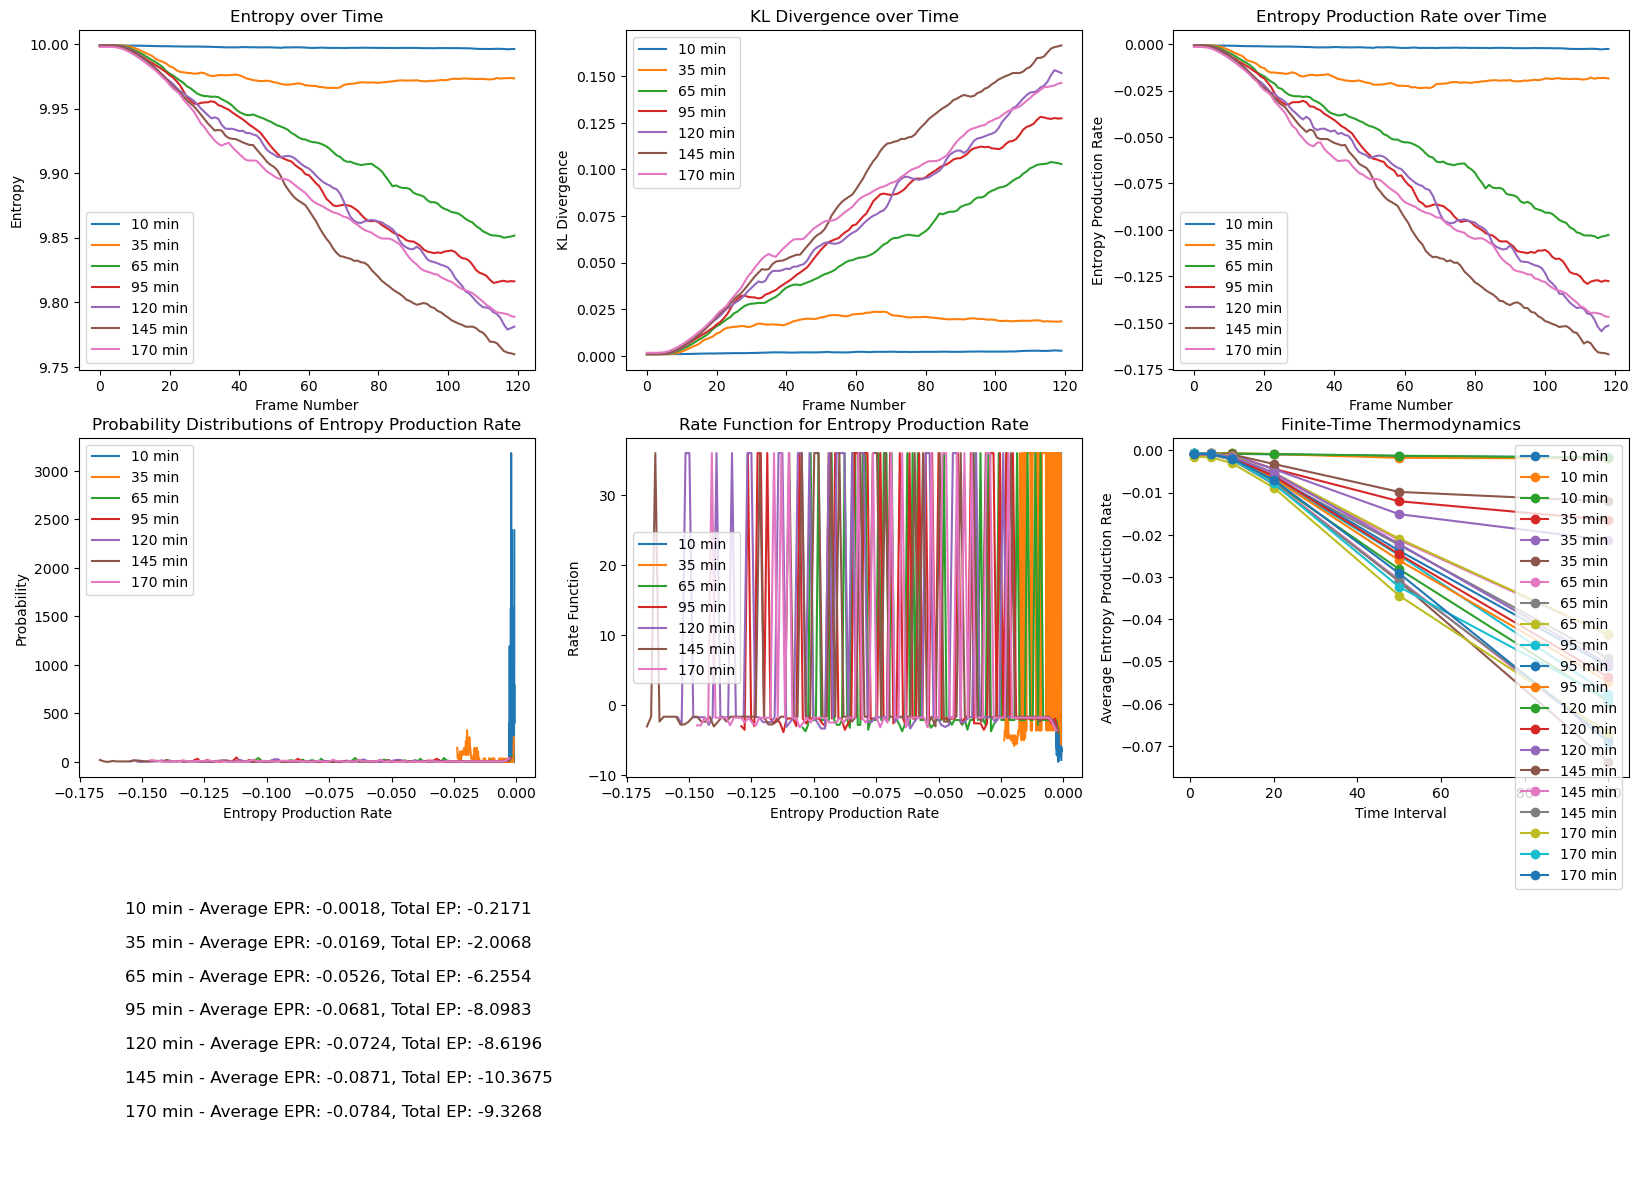

In [12]:
plt.figure(figsize=(20, 15))

# Entropy over Time
plt.subplot(3, 3, 1)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# KL Divergence over Time
plt.subplot(3, 3, 2)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['KL Divergence over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Time')
plt.legend()

# Entropy Production Rate over Time
plt.subplot(3, 3, 3)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy Production Rate'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production Rate')
plt.title('Entropy Production Rate over Time')
plt.legend()

# Probability Distributions of Entropy Production Rate
plt.subplot(3, 3, 4)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Entropy Production Rate Distribution'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Probability')
plt.title('Probability Distributions of Entropy Production Rate')
plt.legend()

# Rate Function for Entropy Production Rate
plt.subplot(3, 3, 5)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Rate Function'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Rate Function')
plt.title('Rate Function for Entropy Production Rate')
plt.legend()

# Finite-Time Thermodynamics
plt.subplot(3, 3, 6)
for incubation_time, group in df.groupby('Incubation Time'):
    for time_intervals, avg_entropy_production_rates in zip(group['Time Intervals'], group['Average Entropy Production Rates']):
        plt.plot(time_intervals, avg_entropy_production_rates, 'o-', label=f'{incubation_time} min')
plt.xlabel('Time Interval')
plt.ylabel('Average Entropy Production Rate')
plt.title('Finite-Time Thermodynamics')
plt.legend()

# Summary of Average and Total Entropy Production
plt.subplot(3, 3, 7)
plt.axis('off')
y_position = 0.8  # Start position for text
for incubation_time, group in df.groupby('Incubation Time'):
    avg_epr = group['Average Entropy Production Rate'].iloc[0]
    total_ep = group['Total Entropy Production'].iloc[0]
    plt.text(0.1, y_position, f'{incubation_time} min - Average EPR: {avg_epr:.4f}, Total EP: {total_ep:.4f}', fontsize=12)
    y_position -= 0.1  # Move to the next line for the next summary



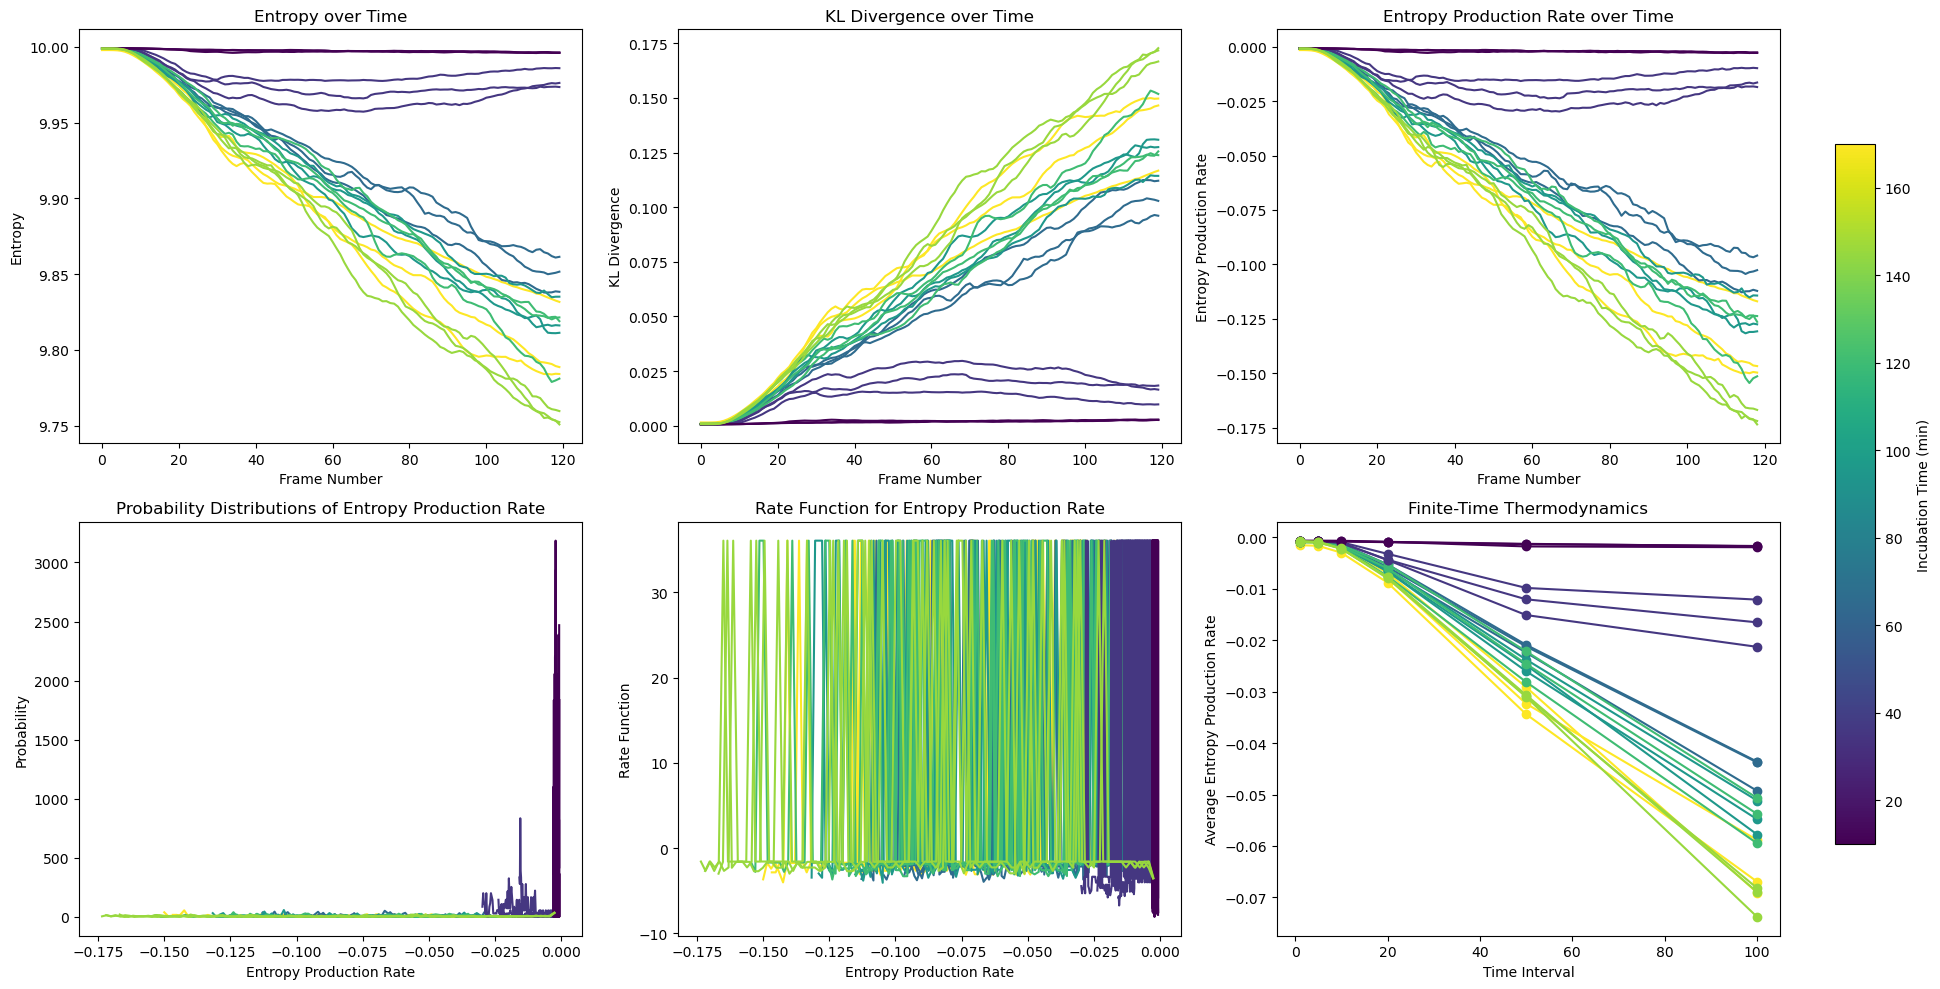

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Assuming 'df' is the DataFrame containing the data

# Extract unique incubation times
incubation_times = df['Incubation Time'].unique()
norm = Normalize(vmin=min(incubation_times), vmax=max(incubation_times))
cmap = plt.get_cmap('viridis')

# Plot the results with incubation time as a color bar
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot 1: Entropy over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 0].plot(row['Entropy over Time'], color=color)
axes[0, 0].set_xlabel('Frame Number')
axes[0, 0].set_ylabel('Entropy')
axes[0, 0].set_title('Entropy over Time')

# Plot 2: KL Divergence over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 1].plot(row['KL Divergence over Time'], color=color)
axes[0, 1].set_xlabel('Frame Number')
axes[0, 1].set_ylabel('KL Divergence')
axes[0, 1].set_title('KL Divergence over Time')

# Plot 3: Entropy Production Rate over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 2].plot(row['Entropy Production Rate'], color=color)
axes[0, 2].set_xlabel('Frame Number')
axes[0, 2].set_ylabel('Entropy Production Rate')
axes[0, 2].set_title('Entropy Production Rate over Time')

# Plot 4: Probability Distributions of Entropy Production Rate
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 0].plot(row['Bins'][:-1], row['Entropy Production Rate Distribution'], color=color)
axes[1, 0].set_xlabel('Entropy Production Rate')
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_title('Probability Distributions of Entropy Production Rate')

# Plot 5: Rate Function for Entropy Production Rate
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 1].plot(row['Bins'][:-1], row['Rate Function'], color=color)
axes[1, 1].set_xlabel('Entropy Production Rate')
axes[1, 1].set_ylabel('Rate Function')
axes[1, 1].set_title('Rate Function for Entropy Production Rate')

# Plot 6: Finite-Time Thermodynamics
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 2].plot(row['Time Intervals'], row['Average Entropy Production Rates'], 'o-', color=color)
axes[1, 2].set_xlabel('Time Interval')
axes[1, 2].set_ylabel('Average Entropy Production Rate')
axes[1, 2].set_title('Finite-Time Thermodynamics')

# Adjust layout to make space for the color bar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add color bar to indicate incubation time outside the plot area on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, cbar_ax, orientation='vertical', label='Incubation Time (min)')

plt.show()
